## <center> École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  INF8460 – Traitement automatique de la langue naturelle <br> </center>
## <center> TP4 - Les LLMs et la génération augmentée de récupération (RAG) pour les questions-réponses<br> Automne 2024 </center>


## 1. Introduction

### 1.1. Description du TP4

Dans ce TP, vous allez travailler sur un système de **génération augmentée de récupération**, ou **RAG** (pour Retrieval Augmented Generation en anglais) qui combine des modèles de langue génératifs et de recherche d'information.

Étant donnée une question, il faudra retrouver les passages les plus pertinents  avec un modèle de recherche. Ensuite, il faudra générer une réponse à la question en utilisant ces passages de texte. Vous aurez finalement à trouver des manières d'améliorer les performances de votre modèle RAG.

L'ensemble est noté sur 100 points.

### Description des données

Les passages donnés sont des textes en anglais de quelques phrases sur divers sujets. Par exemple, les mathématiques, la physique, la chimie, la biologie l'informatique, la musique et la psychologie. En général, les textes abordent des sujets très spécifiques reliés à un domaine. Par exemple, il pourrait y avoir 1000 textes parlant d'informatique et 100 qui abordent, à leur manière, la notion de mémoire. Parmi ces 100 passages, 5 pourraient aborder la mémoire dans un processeur spécifique.

En ce qui concerne les questions, elles sont basées sur les sujets de certains textes précis et on peut y répondre à l'aide d'au moins un des textes. Dans certains cas, plusieurs textes sont nécessaires pour répondre à la question. Par exemple, plusieurs textes pourraient aborder le processeur Intel i7-13700k, mais la question pourrait nécessiter l'information de tous ces textes pour trouver la réponse.
Les questions ont été créées pour faire en sorte que les réponses soient assez courtes. Il peut s'agir d'un simple nombre ou de quelques mots (< 30 mots).


Vous trouverez ~ 13 000 passages dans le corpus pour ~ 1 700 paires de questions / réponses dans le jeu d'entraînement et ~ 500 dans le jeu de validation. Vous devez prédire 500 réponses aux questions du jeu de test.

### Exemple

Par exemple, pour la question

> What type of bonds are used to form branches in glycogen?

Avec l'approche RAG, plutôt que de générer la réponse directement, on va d'abord chercher dans un corpus de passages. Dans cet exemple, un des passages pertinents est :

> **Glycogen Structure and Function** : Glycogen is a molecular polymer of glucose used for energy storage. It is composed of linear chains of glucose molecules linked by α-1,4-glycosidic bonds, with branches formed off the chain via α-1,6-glycosidic bonds. The branches provide additional ""free ends"" for linear chains, allowing for faster glucose release.

Puis on génère une réponse conditionnée par les passages pertinents :

> α-1,6-glycosidic bonds

### Motivation

Le RAG est une approche très populaire en ce moment. Elle permet notamment d'avoir des sources qui supportent les réponses générées, ce qui peut être utile pour la vérification de faits ou pour contrôler les hallucinations. De plus, elle permet d'intégrer des connaissances externes et récentes dans les modèles de génération sans avoir à les ré-entraîner.

### Objectif du TP

Dans ce TP, vous implémenterez plusieurs systèmes de question-réponse. D'abord, vous testerez une approche de prompting qui n'utilise aucun passage pour aider le modèle de génération. Puis vous implémenterez un système figé qui utilise un modèle de plongements figé pour retrouver les $k$ passages les plus pertinents. Ces passages seront ensuite donnés à un modèle de génération figé aussi.

Enfin, vous implémenterez votre propre méthode dans l'objectif d'atteindre les meilleures performances dans la compétition Kaggle.

### Jeux de données

Vous avez 4 fichiers à votre disposition :
- 'rag_texts.csv' : le corpus de passages extraits de Wikipédia.
  - **id** : l'identifiant unique du passage.
  - **text** : le texte du passage.
- 'rag_questions_train.csv', 'rag_questions_val.csv' et 'rag_questions_test.csv' : les questions d'entraînement, de validation et de test.
  - **id** : l'identifiant unique de la question.
  - **question** : La question.
  - **text_id** (sauf pour le fichier de test) : la liste des identifiants des passages pertinents du corpus 'rag_texts.csv' pour la question.
  - **answer** (sauf pour le fichier de test) : la réponse à la question.

### Contraintes

- **Modèle génératif** : pour des raisons d'équité, le seul modèle de génération que vous pouvez utiliser est [microsoft/Phi-3-mini-128k-instruct](https://huggingface.co/microsoft/Phi-3-mini-128k-instruct), disponible sur Hugging Face. Cette contrainte permet de mieux comparer les différentes approches et d'éviter que la performance soit uniquement due à un modèle de génération plus performant.
- Données externes : vous ne pouvez pas utiliser de données externes pour entraîner vos modèles, seulement les données fournies.
- Modèles de plongements à utiliser: [BAAI/bge-small-en-v1.5](https://huggingface.co/BAAI/bge-small-en-v1.5)

### 1.2. Librairies permises

Vous pouvez utiliser les librairies suivantes
- Numpy
- Pandas
- HuggingFace
- nltk
- SpaCy
- PyTorch
- faiss
- Langchain
- re


- Pour toute autre librairie, demandez à votre chargé de laboratoire

### 1.3. Infrastructure

- Vous avez accès aux GPU du local L-4818. Dans ce cas, vous devez utiliser le dossier temp (voir le tutoriel VirtualEnv.pdf)
- Vous pouvez aussi utiliser l’environnement Google Colab :  https://colab.research.google.com/

### 1.5. Kaggle

La compétion Kaggle sera accessible ici: https://www.kaggle.com/t/c970abbf273b4e13a642fce3bfe219be.

Vous devez recréer des équipes de 3 personnes sur Kaggle avec le même nom d'équipe que sur Moodle ainsi que les mêmes membres.

Le TP4 se fera sous forme d’une compétition Kaggle.  Vous devrez utiliser l’environnement Kaggle pour la soumission et l’évaluation de vos meilleurs modèles.  
Pour tester votre modèle au fur et à mesure, vous aurez le droit à 4 soumissions par jour sur Kaggle. Il y aura deux types de résultats : votre « private leaderboard » et votre « public leaderboard » :
- Le « public leaderboard » est calculé sur approximativement 30% des données de test, choisies aléatoirement par Kaggle. Ce score est public et est calculé sur la même tranche de données pour tous les participants.
- Le « private leaderboard » est calculé sur approximativement 70% des données de test et n’est visible qu’à la fin de la compétition. Le résultat final sera basé sur ce leaderboard. Si aucune soumission n’est choisie, la soumission avec le meilleur score sur le « public leaderboard » sera utilisée pour calculer le score sur le « private leaderboard ».

Pour l’évaluation, vous devrez soumettre un fichier de données _tp4_submission.csv_ du même format que le fichier _sample_submission.csv_ (disponible sur le site de la compétition et Moodle).


### 1.6. Description des données et métriques d’évaluation

Dans votre fichier de soumission, il doit y avoir une colonne _id_ et une colonne _answer_. La colonne _id_ doit correspondre à l'identifiant unique de la question et la colonne _answer_ doit correspondre à la réponse générée par votre modèle.

Nous utiliserons la métrique **BLEU**, vue en cours, pour évaluer les réponses générées par rapport au jeu de référence (gold standard).

In [2]:
# Import des librairies

import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    AutoModelForSeq2SeqLM,
    AutoModel,
    TrainingArguments
)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from datetime import datetime
from datasets import load_dataset, Dataset
import nltk
import faiss
import re
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.functional import normalize
import torch.nn.functional as F
import ast

In [3]:
# Si vous stockez vos données sur Google Drive

# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
root_path = './'
data_path = root_path + 'data/'
generated_path = root_path + 'generated/'

## 2. Analyse exploratoire et modèle de génération simple (15 points)

Pour commencer ce TP, et pour fixer des modèles de base (baselines), vous allez utiliser un modèle de génération simple pour répondre aux questions. Vous utiliserez le modèle de génération **'microsoft/Phi-3-mini-128k-instruct'** disponible sur Hugging Face. Dans cette partie, vous devez simplement générer des réponses aux questions de l'ensemble de validation (_questions_val.csv_) sans utiliser de passages pour aider le modèle.

### 2.1. Chargement des données (5 points)

#### 2.1.1 Taille des données (1 point)

Affichez la taille de tous les jeux de données et quelques questions de l'ensemble d'entraînement

In [5]:
# TODO
questions_train_df = pd.read_csv(data_path + 'questions_train.csv')
id_index = questions_train_df.columns.get_loc('id')
questions_train_df = questions_train_df.iloc[:, id_index:]
print(f'La taille de questions_train_df est :', questions_train_df.shape)

questions_val_df = pd.read_csv(data_path + 'questions_val.csv')
id_index = questions_val_df.columns.get_loc('id')
questions_val_df = questions_val_df.iloc[:, id_index:]
print(f'La taille de questions_val_df est :', questions_val_df.shape)

questions_test_df = pd.read_csv(data_path + 'questions_test.csv')
id_index = questions_test_df.columns.get_loc('id')
questions_test_df = questions_test_df.iloc[:, id_index:]
print(f'La taille de questions_test_df est :', questions_test_df.shape)

texts_df = pd.read_csv(data_path + 'texts.csv')
id_index = texts_df.columns.get_loc('id')
texts_df = texts_df.iloc[:, id_index:]
print(f'La taille de texts_df est :', texts_df.shape)

questions_train_df.head()
# END TODO

La taille de questions_train_df est : (1747, 4)
La taille de questions_val_df est : (500, 4)
La taille de questions_test_df est : (500, 2)
La taille de texts_df est : (13314, 2)


,id,text_ids,question,answer
0,2303,[9797 8675 11007 4654],What type of insects are vectors for the Haemo...,"Ceratopogonidae, Culicidae, and Nycteribiidae"
1,2310,[736 9830 5892 3158],What is the basis of the security of the BBS a...,The computational difficulty of factoring larg...
2,2548,[10371 6103],What is the purpose of the catalase test in ba...,To identify bacterial species and determine th...
3,552,[11829 6677 7137],What type of cells clear small particles in ve...,Scavenger endothelial cells
4,1822,[4105 1016],What information is needed to decrypt a messag...,The user's private key


#### 2.1.2 Analyse exploratoire (4 points)

a) Sur l'ensemble d'entraînement, affichez :
- Le nombre moyen de mots dans une question
- Le nombre moyen de mots dans une réponse
- Le nombre moyen de passages nécessaires pour répondre à une question
- Le nombre minimal de passages nécessaires pour répondre à une question
- Le nombre maximal de passages nécessaires pour répondre à une question


In [6]:
# TODO
average_words_question = questions_train_df['question'].str.split().apply(len).mean()
print(f"Nombre moyen de mots dans une question : {average_words_question:.2f}")

average_words_answer = questions_train_df['answer'].str.split().apply(len).mean()
print(f"Nombre moyen de mots dans une réponse : {average_words_answer:.2f}")

average_passages = questions_train_df['text_ids'].str.split().apply(len).mean()
print(f"Nombre moyen de passages nécessaires pour répondre à une question : {average_passages:.2f}")

min_passages = questions_train_df['text_ids'].str.split().apply(len).min()
print(f"Nombre minimal de passages nécessaires pour répondre à une question : {min_passages}")

max_passages = questions_train_df['text_ids'].str.split().apply(len).max()
print(f"Nombre maximal de passages nécessaires pour répondre à une question : {max_passages}")
# END TODO

Nombre moyen de mots dans une question : 10.37
Nombre moyen de mots dans une réponse : 6.08
Nombre moyen de passages nécessaires pour répondre à une question : 2.84
Nombre minimal de passages nécessaires pour répondre à une question : 2
Nombre maximal de passages nécessaires pour répondre à une question : 4


b) De plus, affichez des histogrammes décrivant la distribution du nombre de mots des questions, des réponses et des textes. Utilisez des bacs (bins) de 50. Commentez vos résultats.

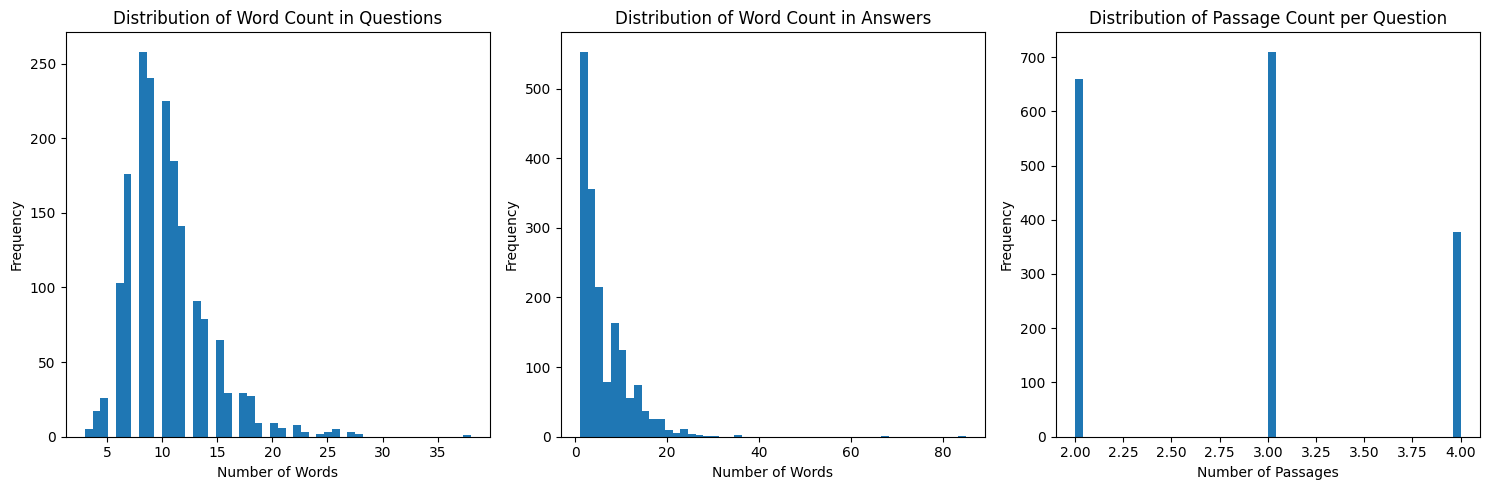

In [7]:
# TODO
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(questions_train_df['question'].str.split().apply(len), bins=50)
axes[0].set_title('Distribution of Word Count in Questions')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')

axes[1].hist(questions_train_df['answer'].str.split().apply(len), bins=50)
axes[1].set_title('Distribution of Word Count in Answers')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')

axes[2].hist(questions_train_df['text_ids'].str.split().apply(len), bins=50)
axes[2].set_title('Distribution of Passage Count per Question')
axes[2].set_xlabel('Number of Passages')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
# TODO

COMMENTAIRE:

Nombre de mots dans les questions : La plupart des questions contiennent entre 5 et 15 mots, avec une moyenne de 10,37 mots. Cela indique des questions courtes et précises.

Nombre de mots dans les réponses : Les réponses sont encore plus courtes, avec une moyenne de 6,08 mots. La majorité des réponses sont brèves, bien que certaines soient plus détaillées.

Nombre de passages par question : En moyenne, chaque question nécessite environ 2,84 passages, avec un minimum de 2 et un maximum de 4 passages. Cela montre que les questions nécessitent un contexte modéré, sans être trop complexes.

### 2.2. Chargement du modèle et génération des réponses (5 points)

Nous allons maintenant évaluer la performance d'un modèle de langue à répondre aux questions de l'ensemble de validation. Chargez d'abord le modèle **'microsoft/Phi-3-mini-128k-instruct'** avec la librairie `transformers` de huggingface et générez les réponses du modèle à partir de la question. Générez au maximum 32 nouveaux jetons.

In [8]:
import gc

torch.manual_seed(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
quantization_config = BitsAndBytesConfig(load_in_8bit=True)

def clean_cuda():
  if torch.cuda.is_available():
      torch.cuda.empty_cache()
      torch.cuda.reset_peak_memory_stats()
      gc.collect()
      print(f"GPU memory cleaned")

In [10]:
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-128k-instruct",
    device_map=device,
    torch_dtype=torch.float16,
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-128k-instruct")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
DEFAULT_RESPONSE = "I'm not sure about that."

def build_prompt(question, base_prompt="You are a concise and precise assistant. Limit answers to one sentence."):
    """
    Build a conversational prompt for a given question.
    """
    prompt_template = [
        {"role": "system", "content": base_prompt},
        {"role": "user", "content": question},
        {"role": "assistant", "content": "Answer:"}
    ]
    return "\n".join([f"{item['role']}: {item['content']}" for item in prompt_template])

def extract_first_sentence(text):
    """
    Extract the first sentence from a given text.
    """
    sentences = re.split(r"[.!?\n]", text.strip())
    return sentences[0].strip() if sentences else text

def generate_answers(dataset: Dataset, batch_size=32) -> Dataset:
    """
    Generate answers for each question in the dataset using the model and tokenizer.
    """
    prompts = [build_prompt(question) for question in dataset['question']]
    answers = []

    for i in tqdm(range(0, len(prompts), batch_size), desc="Generating answers"):
        batch_prompts = prompts[i:i + batch_size]
        inputs = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(model.device)

        with torch.no_grad():
            generated_tokens = model.generate(
                inputs.input_ids,
                attention_mask=inputs.attention_mask,
                max_new_tokens=32,
                do_sample=True,
                top_p=0.95,
                temperature=0.7
            )

        decoded_answers = tokenizer.batch_decode(
            generated_tokens[:, inputs['input_ids'].shape[1]:],
            skip_special_tokens=True
        )

        for decoded_answer in decoded_answers:
            first_sentence = extract_first_sentence(decoded_answer)
            answers.append(first_sentence or DEFAULT_RESPONSE)

    return Dataset.from_dict({"id": dataset['id'], "answer": answers})

In [12]:
answers_dataset = generate_answers(questions_val_df)
output_filename = f"val_2_2_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
answers_dataset.to_csv(generated_path + output_filename, index=False)
answers_dataset.select(range(5)).to_pandas().head()

Generating answers:   0%|          | 0/16 [00:00<?, ?it/s]The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
You are not running the flash-attention implementation, expect numerical differences.
Generating answers: 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]


Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

,id,answer
0,780,It reduces responsiveness to LTD4
1,1870,Carbapenems have a different core ring structu...
2,654,4-dimensional hypercubic facets
3,2538,5F-AMB is a controlled substance under the Con...
4,745,Estrone


### 2.3. Évaluation des réponses (3 points)

Complétez la fonction `evaluate_bleu` et utilisez la métrique BLEU pour évaluer les réponses générées par rapport aux réponses attendues sur le jeu de validation. Évaluez votre modèle avec les métriques BLEU-1 et BLEU-2. BLEU-1 ne considère que les unigrammes pour évaluer la réponse et BLEU-2 considère les bigrammes aussi. Pour séparer une séquence en mots, vous pouvez simplement utiliser la fonction `split()`.

In [13]:
def evaluate_bleu(df_true: pd.DataFrame, df_pred: pd.DataFrame, bleu_type: int) -> float:
    """
    Evaluate generated responses using the BLEU metric.

    Parameters:
    - df_true (pd.DataFrame): DataFrame containing the true answers with columns 'id' and 'answer'.
    - df_pred (pd.DataFrame): DataFrame containing the predicted answers with columns 'id' and 'answer'.
    - bleu_type (int): Specifies the n-gram BLEU type (1 for BLEU-1, 2 for BLEU-2).

    Returns:
    - float: The average BLEU score across all entries, scaled by 100.
    """
    weights = (1.0, 0, 0, 0) if bleu_type == 1 else (0.5, 0.5, 0, 0)
    smoothing_function = SmoothingFunction().method1
    bleu_scores = [
        sentence_bleu([true_answer.split()], pred_answer.split(), weights, smoothing_function=smoothing_function)
        if true_answer and pred_answer else 0.0
        for true_answer, pred_answer in zip(df_true['answer'], df_pred['answer'])
    ]
    return np.mean(bleu_scores) * 100 if bleu_scores else 0.0

In [14]:
bleu = {
    'BLEU-1': evaluate_bleu(questions_val_df, answers_dataset.to_pandas(), 1),
    'BLEU-2': evaluate_bleu(questions_val_df, answers_dataset.to_pandas(), 2)
}
for key, value in bleu.items():
    print(f'{key} : {value:.2f}%')

BLEU-1 : 18.27%
BLEU-2 : 10.39%


### 2.4. Commentaire (2 points)

Reportez, puis commentez la performance obtenue ici.

In [15]:
questions_test_ds_answers = generate_answers(questions_test_df)
questions_test_ds_answers.to_csv(generated_path + f'test_2_4_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv', index=False)
questions_test_ds_answers.select(range(5)).to_pandas().head()

Generating answers: 100%|██████████| 16/16 [00:21<00:00,  1.34s/it]


Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

,id,answer
0,792,An expectorant and a treatment for hyperacidity
1,507,"Ciliates, such as Paramecium, have lost multic..."
2,1409,Chromosome 17
3,1369,Photometry
4,1198,The length of FAM166A in amino acids is not sp...


Performance obtenue:

Les résultats obtenus (BLEU-1 : 18.37%, BLEU-2 : 10.36%, Kaggle : 0.06199) sont faibles et c’est normal car le modèle n’a pas été entraîné pour cette tâche spécifique et aucun contexte précis n’a été donné. Avec un entraînement adapté et du contexte, les performances seront meilleures.

## 3. Approche RAG figé (45 points)

Dans cette partie, vous allez implémenter une approche simple de RAG figé. On dit ici que le modèle est figé car on ne ré-entraîne aucun modèle. Vous implémenterez deux variantes : avec ou sans l'utilisation d'un algorithme d'indexation.

Dans la méthode d'implémentation du RAG figé, vous allez d'abord retrouver les passages pertinents pour chaque question avec un modèle de plongements de type Transformers, puis générer une réponse conditionnée par ces passages.

Dans cette partie, on utilisera
- le modèle de plongements (embedding-model) **[BAAI/bge-small-en-v1.5](https://huggingface.co/BAAI/bge-small-en-v1.5)** pour obtenir les vecteur de plongements des questions et des passages
- le modèle de génération (generative-model) **[microsoft/Phi-3-mini-128k-instruct](https://huggingface.co/microsoft/Phi-3-mini-128k-instruct)** pour générer les réponses

### 3.1 RAG figé sans indexation (23 points)

#### 3.1.1 Passages pertinents (8 points)

Pour retrouver les passages pertinents, vous devez d'abord encoder les questions et les passages avec le modèle de plongements. Puis, vous devez calculer la similarité cosinus entre les questions et les passages pour retrouver les $k$ passages les plus pertinents pour chaque question.

In [16]:
# # TODO
embedding_model = AutoModel.from_pretrained("BAAI/bge-small-en-v1.5",
    device_map='cuda',
    torch_dtype=torch.float16,
    trust_remote_code=True,
)
embedding_tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-small-en-v1.5")
# # END TODO

In [17]:
def encode_sequences(sequences: list, tokenizer, model, device, batch_size=64):
    """
    Encode texts using the provided model to generate text embeddings.

    Parameters:
    sequences    : List of sequences to encode as embeddings
    tokenizer    : Tokenizer for the embedding model
    model        : Embedding model (already loaded on CUDA if applicable)
    device       : Device for performing computations (e.g., 'cuda' or 'cpu')
    batch_size   : Batch size for processing

    Returns:
    torch.Tensor : Combined embeddings for all sequences
    """
    embeddings = []
    model.eval()
    mixed_precision = torch.cuda.is_available()

    with torch.no_grad(), torch.amp.autocast(device_type='cuda', enabled=mixed_precision):
        for i in tqdm(range(0, len(sequences), batch_size), desc="Encoding sequences"):
            batch = sequences[i:i + batch_size]
            inputs = tokenizer(batch, padding=True, truncation=True, return_tensors='pt', return_token_type_ids=False).to(device)
            outputs = model(**inputs)
            embedding_layer = outputs.last_hidden_state
            embeddings.append(embedding_layer.mean(dim=1))

    return torch.cat(embeddings, dim=0)

In [18]:
# TODO
passages_embed = encode_sequences(texts_df['text'].to_list(), embedding_tokenizer, embedding_model, device=device)
# END TODO

Encoding sequences: 100%|██████████| 209/209 [00:02<00:00, 94.66it/s]


#### 3.1.2 Évaluation des passages retrouvés avec Recall@k et precision@k (7 points)

Maintenant que les passages ont tous été encodés, on peut évaluer si les passages retrouvés sont pertinents. En prenant les $k$ premiers passages, on peut évaluer si on retrouve les bons passages associés aux questions. C'est un des avantages du système RAG : on peut évaluer de façon indépendante la qualité du système qui retrouve les passages pertinents et de celui qui génère les réponses. Cela permet notamment d'évaluer quels sont les points forts et points faibles du système.

Pour cela, vous allez utiliser les métriques **Precision@k** et **Recall@k** définies dans les équations suivantes. Implémentez ces métriques.

$$\text{Precision@k} = \frac{\text{Nombre d'éléments pertinents dans les k premiers}}{k}$$

$$\text{Recall@k} (Rappel@k) = \frac{\text{Nombre d'éléments pertinents dans les k premiers}}{\text{Nombre total d'éléments pertinents}}$$


In [19]:
def compute_recall_at_k(ground_truth, predictions):
    """
    Calcule la métrique du "Recall@k". On assume que predictions contiennent le bon nombre de passages (=k)

    Paramètres:
    ground_truth : Liste contenant tous les vrais passages associés aux questions (ex : [[1, 2, 3], [4, 5, 6]] si les passages de la question 1 sont [1, 2, 3] et
    les passages de la question 2 sont [4, 5, 6])
    predictions : Liste contenant tous les passages retrouvés pour chacune des questions formattée de la même manière que `ground_truth`

    Retourne:
    Recall moyen
    """
    # TODO
    total_recall = sum(
        len(set(predicted) & set(true)) / len(true) if true else 0
        for true, predicted in zip(ground_truth, predictions)
    )
    return total_recall / len(ground_truth) if ground_truth else 0
    # END TODO

In [20]:
def compute_precision_at_k(ground_truth, predictions):
    """
    Calcule la métrique du "Precision@k". On assume que predictions contiennent le bon nombre de passages (=k)

    Paramètres:
    ground_truth : Liste contenant tous les vrais passages associés aux questions (ex : [[1, 2, 3], [4, 5, 6]] si les passages de la question 1 sont [1, 2, 3] et
    les passages de la question 2 sont [4, 5, 6])
    predictions : Liste contenant tous les passages retrouvés pour chacune des questions formattée de la même manière que `ground_truth`

    Retourne:
    Précision moyenne
    """
    # TODO
    total_precision = sum(
        len(set(predicted) & set(true)) / len(predicted) if predicted else 0
        for true, predicted in zip(ground_truth, predictions)
    )
    return total_precision / len(ground_truth) if ground_truth else 0
    # END TODO

#### 3.1.3 Résultat d'évaluation (5 points)
Implémentez la fonction _'retrieve_passages'_ qui retourne les indices des $k$ passages les plus similaires pour une question. Utilisez la similarité cosinus pour comparer les passages et les questions. Évaluez ensuite votre modèle récupérant les passages avec les métriques Precision@k et Recall@k sur le jeu de validation. Calculez avec $k={1, 2, 3, 4, 5}$.

In [21]:
def retrieve_passages(questions: list, passage_embed: torch.Tensor, k: int, embedding_model_tokenizer, embedding_model, device='cuda'):
    """
    Retourne les k passages les plus pertinents pour chaque question passée en paramètre

    Paramètres:
    questions       : Les questions pour lesquelles on cherche les passages les plus pertinents
    passage_embed   : Tenseur contenant les plongements de chaque passage (n, dim)
    k               : le nombre de passages à retourner
    embedding_model_tokenizer : Segmenteur du modèle de plongements
    embedding_model : Modèle de plongements

    Retourne:
    Les indices des k passages les plus pertinents pour chaque question
    """
    questions_embed = encode_sequences(questions, embedding_model_tokenizer, embedding_model, device=device)
    
    if isinstance(passage_embed, np.ndarray):
        passage_embed = torch.tensor(passage_embed, device=device)
    
    questions_embed = questions_embed.unsqueeze(1)
    passage_embed = passage_embed.unsqueeze(0)
    
    cosines = F.cosine_similarity(questions_embed, passage_embed, dim=-1)
    return cosines.topk(k, dim=1, largest=True).indices

In [22]:
# TODO
k_values = range(1, 6)

questions_list = questions_val_df['question'].tolist()
ground_truth = [list(map(int, text_ids.strip("[]").split())) for text_ids in questions_val_df['text_ids']]

recall_at_k = []; precision_at_k = []
for k in tqdm(k_values, desc="Computing metrics"):
    clean_cuda()
    top_k_indices = retrieve_passages(questions_list, passages_embed.cpu().numpy(), k, embedding_tokenizer, embedding_model).cpu().numpy().tolist()
    recall_at_k.append(compute_recall_at_k(ground_truth, top_k_indices))
    precision_at_k.append(compute_precision_at_k(ground_truth, top_k_indices))
# END TODO

Computing metrics:   0%|          | 0/5 [00:00<?, ?it/s]

GPU memory cleaned


Computing metrics:  20%|██        | 1/5 [00:00<00:01,  2.54it/s]

GPU memory cleaned


Computing metrics:  40%|████      | 2/5 [00:01<00:01,  1.78it/s]

GPU memory cleaned


Computing metrics:  60%|██████    | 3/5 [00:01<00:01,  1.62it/s]

GPU memory cleaned


Computing metrics:  80%|████████  | 4/5 [00:02<00:00,  1.56it/s]

GPU memory cleaned


Computing metrics: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


In [23]:
for k, recall, precision in zip(k_values, recall_at_k, precision_at_k):
    print(f"Precision@{k}: {precision*100:.2f}%")
    print(f"Recall@{k}: {recall *100:.2f}%")

Precision@1: 89.00%
Recall@1: 33.28%
Precision@2: 67.50%
Recall@2: 49.15%
Precision@3: 56.27%
Recall@3: 60.78%
Precision@4: 49.95%
Recall@4: 70.93%
Precision@5: 44.32%
Recall@5: 78.32%


#### 3.1.4 Graphique (3 points)
Affichez maintenant un graphique de vos résultats de la question précédente en mettant à l'axe des x la valeur de $k$ et à l'axe des y la valeur de la précision et du rappel. Quel est le nombre optimal de passages à passer au modèle en vous basant sur le recall@k et precision@k ? Pourquoi ?

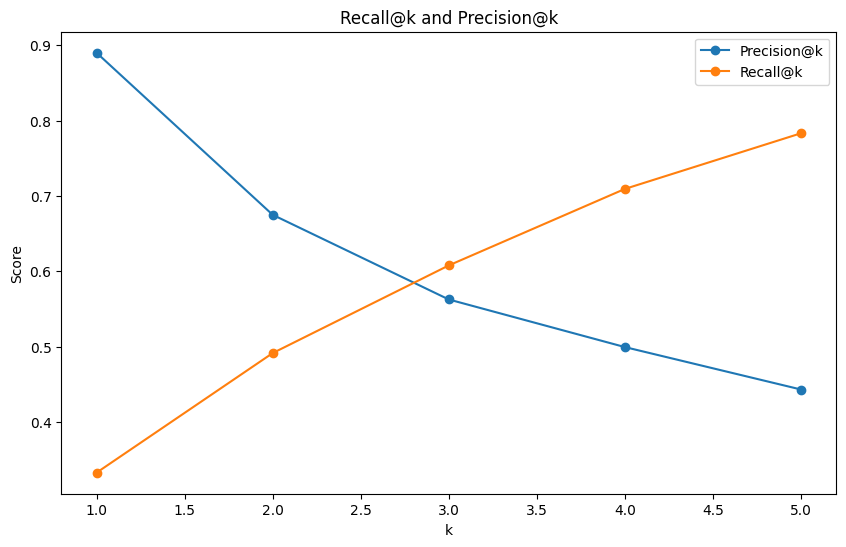

In [24]:
# TODO
def plot_metrics(k, recall_at_k, precision_at_k):
    """
    Plot the Recall@k and Precision@k metrics.

    Parameters:
    k             : List of k values
    recall_at_k   : List of Recall@k scores
    precision_at_k: List of Precision@k scores
    """
    plt.figure(figsize=(10, 6))
    plt.plot(k, precision_at_k, label='Precision@k', marker='o')
    plt.plot(k, recall_at_k, label='Recall@k', marker='o')
    plt.xlabel('k')
    plt.ylabel('Score')
    plt.title('Recall@k and Precision@k')
    plt.legend()
    plt.show()

plot_metrics(k_values, recall_at_k, precision_at_k)
# END TODO

Si l'on cherche un compromis entre précision et rappel, k=3 représente le meilleur choix, car le rappel (60,78%) et la précision (56,27%) sont relativement bien équilibrés, offrant un compromis acceptable entre la couverture des éléments pertinents et la limitation des faux positifs.

### 3.2 RAG figé avec FAISS (14 points)

Maintenant on vous demande d'utiliser FAISS pour l'indexation des plongements des passages.

[FAISS (Facebook AI Similarity Search)](https://ai.meta.com/tools/faiss/) est une bibliothèque open-source développée par Meta pour la recherche de similarité rapide sur des vecteurs denses, comme des embeddings de textes ou d'images. Elle est optimisée pour gérer de grands volumes de données en haute dimension et peut être accélérée avec des GPU. FAISS est largement utilisée pour des systèmes de recommandation ou la recherche d'information à grande échelle. Pour plus de détails, veuillez consulter  [le tutoriel sur Moodle](https://moodle.polymtl.ca/course/view.php?id=2813).


#### 3.2.1 Initialisez l'indexation FAISS avec les plongements des passages (2 points)

Utilisez les plongements des passages générés au niveau de la question 3.1.1 et indexez-les avec FAISS. Vérifiez que le nombre de plongements dans l'objet FAISS est bien le même que le nombre de passages. N'oubliez pas qu'on veut une indexation basée sur la similarité cosinus.

In [25]:
# TODO
passages_embed_np = passages_embed.cpu().numpy().astype('float32')
faiss.normalize_L2(passages_embed_np)

d = passages_embed_np.shape[1]
index = faiss.IndexFlatIP(d)
index.add(passages_embed_np)

assert index.ntotal == len(passages_embed_np), ("Mismatch between the number of embeddings in the FAISS index and the passages.")
# END TODO

#### 3.2.2 Récupération des passages avec FAISS (4 points)

Implémentez la fonction _'retrieve_passages_faiss'_ qui retourne les indices des $k$ passages les plus similaires pour une question à l'aide d'un indexation FAISS


In [26]:
def retrieve_passages_faiss(questions: list, vector_index: faiss.IndexFlatL2, k: int, embedding_model_tokenizer, embedding_model, device='cuda'):
    """
    Retourne les k passages les plus pertinents pour chaque question passée en paramètre.

    Paramètres:
    questions       : list : Les questions pour lesquelles on cherche les passages les plus pertinents
    vector_index    : faiss.IndexFlatL2 : L'objet d'indexation FAISS
    k               : int : le nombre de passages à retourner
    embedding_model_tokenizer : Tokenizer : Segmenteur du modèle de plongements
    embedding_model : Model : Modèle de plongements
    device          : str : L'appareil à utiliser pour les plongements ('cpu' ou 'cuda')

    Retourne:
    top_k_indices   : list : Les indices des k passages les plus pertinents pour chaque question.
    """
    questions_embed = encode_sequences(questions, embedding_model_tokenizer, embedding_model, device=device)
    questions_embed = questions_embed.detach().cpu().numpy().astype('float32')
    _, top_k_indices = vector_index.search(questions_embed, k)
    return top_k_indices

#### 3.2.3 Exécution de FAISS (4 points)

Exécutez maintenant la fonction _"retrieve_passages_faiss"_ pour récupérer les bons passages pour les questions du jeu de validation avec votre k optimal.

In [27]:
# TODO
k_optimal = 3
relevant_passages = retrieve_passages_faiss(questions_val_df['question'].to_list(), index, k_optimal, embedding_tokenizer, embedding_model)
# END TODO

Encoding sequences: 100%|██████████| 8/8 [00:00<00:00, 111.95it/s]


#### 3.2.4 Calculez les métriques Precision@K et Rappel@K pour les passages retrouvés avec FAISS avec votre k optimal (2 points)

In [28]:
# TODO
predictions = [[texts_df['id'][idx] for idx in index_list] for index_list in relevant_passages]
ground_truth = [list(map(int, gt.replace('[', '').replace(']', '').split())) for gt in questions_val_df['text_ids']]
precision_at_k = compute_precision_at_k(ground_truth, predictions)
recall_at_k = compute_recall_at_k(ground_truth, predictions)
print(f"Precision@{k_optimal}: {precision_at_k * 100:.2f}%")
print(f"Recall@{k_optimal}: {recall_at_k *100:.2f}%")
# END TODO

Precision@3: 56.27%
Recall@3: 60.78%


#### 3.2.5 Quelle remarque pouvez-vous faire sur l'utilisation de FAISS en termes de passages retrouvés, de temps d'exécution et de tout autre élément qui vous semble approprié ? (2 points)

Sans FAISS : 
Precision@3: 56.27%
Recall@3: 60.78%

Avec FAISS : 
Precision@3: 56.27%
Recall@3: 60.78%

Bien que les valeurs de précision et de rappel restent identiques dans les deux cas, une amélioration est observée au niveau du temps d'exécution. Sans FAISS, les passages sont retrouvés en environ 3 secondes, tandis qu’avec FAISS, ce temps est réduit à moins de 0,5 seconde. Cette différence est attribuée aux optimisations spécifiques de FAISS, qui est conçu pour accélérer les recherches de similarité.

### 3.3 Génération des réponses (5 points)

Générez maintenant les réponses des questions sur l'ensemble de validation avec les passages récupérés. Pour générer les réponses, vous devez concaténer les passages pertinents avec la question et donner le tout au modèle de génération. Faites-le sur l'ensemble du jeu de validation. Pour la méthode, vous avez le choix entre les passages retrouvés avec FAISS ou manuellement (avec votre propre implémentation). Faites cela pour toutes les valeurs de $k$: (1, 2, 3 et 4).

In [29]:
# TODO
def generate_prompts(questions, passages_indices, passages, k_values):
    """
    Génère des prompts pour chaque question, en combinant la question avec les passages les plus pertinents.

    Paramètres:
    questions        : list : Liste de questions pour lesquelles générer des prompts.
    passages_indices : list : Liste des indices de passages pertinents pour chaque question.
    passages         : list : Liste de passages textuels disponibles.
    k_values         : list : Liste de valeurs de k, représentant le nombre de passages à inclure.

    Retourne:
    prompts_by_k     : dict : Dictionnaire contenant des listes de prompts pour chaque valeur de k.
    """
    prompts_by_k = {k: [] for k in k_values}
    base_prompt = "You are a concise and precise assistant. Limit answers to one sentence."

    for i, question in enumerate(questions):
        for k in k_values:
            relevant_passages = ' '.join([passages[idx] for idx in passages_indices[i][:k]])
            messages = [
                {"role": "system", "content": base_prompt},
                {"role": "user", "content": f"Context: {relevant_passages}"},
                {"role": "user", "content": question},
                {"role": "assistant", "content": "Answer:"}
            ]
            prompt = "\n".join([f"{msg['role']}: {msg['content']}" for msg in messages])
            prompts_by_k[k].append(prompt)

    return prompts_by_k
# END TODO

Affichez un exemple d'invite (prompt) qui sera envoyé au modèle de génération

In [30]:
# TODO
prompts_by_k = generate_prompts(questions_val_df['question'].to_list(), relevant_passages, texts_df['text'].to_list(), k_values)
print(prompts_by_k[1][:5])
# END TODO

['system: You are a concise and precise assistant. Limit answers to one sentence.\nuser: Context:  Polymorphism in the CYSLTR2 gene has been associated with the inheritance of asthma in separate populations. The M201V variant of CYSLTR2 exhibits decreased responsiveness to LTD4, suggesting that this hypo-responsiveness underlies its asthma transmission-protecting effect.\nuser: What is the effect of the M201V variant of CYSLTR2 on responsiveness to LTD4?\nassistant: Answer:', 'system: You are a concise and precise assistant. Limit answers to one sentence.\nuser: Context:   Carbapenems are structurally similar to penicillins, but with a carbon atom replacing the sulfur atom in position 1. They are biosynthesized through a series of steps involving the condensation of malonyl-CoA with glutamate-5-semialdehyde, followed by the formation of the β-lactam and saturated carbapenam core.\nuser: What is the key difference in the structure of carbapenems compared to penicillins?\nassistant: Answ

In [31]:
# TODO
def generate_answers_with_prompts(prompts, model, tokenizer, device='cuda', batch_size=4):
    """
    Génère des réponses pour chaque prompt en utilisant le modèle de génération de texte.

    Paramètres:
    prompts  : dict : Dictionnaire contenant des listes de prompts pour chaque valeur de k.
    model    : Model : Modèle de génération de texte.
    tokenizer: Tokenizer : Segmenteur du modèle.
    device   : str : L'appareil à utiliser pour les plongements ('cpu' ou 'cuda').
    batch_size: int : Taille du lot pour le traitement.

    Retourne:
    answers  : dict : Dictionnaire contenant des listes de réponses pour chaque valeur de k.
    """
    clean_cuda()
    answers = {k: [] for k in prompts.keys()}

    for k, prompt_list in prompts.items():
        if len(prompt_list) == 0:
            print(f"Skipping k={k} due to empty prompts")
            continue

        for i in tqdm(range(0, len(prompt_list), batch_size), desc=f"Generating answers for k={k}"):
            batch_prompts = prompt_list[i:i + batch_size]
            inputs = tokenizer(batch_prompts, return_tensors='pt', padding=True, truncation=True).to(device)

            with torch.no_grad():
                gen_tokens = model.generate(
                    inputs.input_ids,
                    attention_mask=inputs.attention_mask,
                    max_new_tokens=64,
                    do_sample=True,
                    top_p=0.95,
                    temperature=0.7
                )

            batch_answers = tokenizer.batch_decode(gen_tokens[:, inputs['input_ids'].shape[1]:], skip_special_tokens=True)
            answers[k].extend([extract_first_sentence(answer) or DEFAULT_RESPONSE for answer in batch_answers])

    return answers
# END TODO

In [32]:
output_df_faiss = generate_answers_with_prompts(prompts_by_k, model, tokenizer, device=device, batch_size=32)

GPU memory cleaned


Generating answers for k=5: 100%|██████████| 16/16 [01:06<00:00,  4.15s/it]


### 3.4 Évaluation des réponses (3 points)

Utilisez la métrique BLEU (BLEU-1 et BLEU-2) pour évaluer les réponses générées par rapport aux réponses attendues sur le jeu de validation.

In [33]:
# TODO
bleu_scores_faiss = {}
for k, answers in output_df_faiss.items():
    faiss_df = pd.DataFrame({'id': questions_val_df['id'], 'answer': answers})
    bleu1 = evaluate_bleu(questions_val_df, faiss_df, 1)
    bleu2 = evaluate_bleu(questions_val_df, faiss_df, 2)
    bleu_scores_faiss[k] = (bleu1, bleu2)

for k, (bleu1, bleu2) in bleu_scores_faiss.items():
    print(f"BLEU-1 score for k={k}: {bleu1:.2f}%")
    print(f"BLEU-2 score for k={k}: {bleu2:.2f}%")
# END TODO

BLEU-1 score for k=1: 54.53%
BLEU-2 score for k=1: 44.06%
BLEU-1 score for k=2: 57.70%
BLEU-2 score for k=2: 47.80%
BLEU-1 score for k=3: 57.33%
BLEU-2 score for k=3: 47.19%
BLEU-1 score for k=4: 58.85%
BLEU-2 score for k=4: 48.43%
BLEU-1 score for k=5: 59.16%
BLEU-2 score for k=5: 49.06%


En vous basant sur les résultats de génération du modèle sur l'ensemble de validation, quel est le nombre optimal de passages à passer au modèle ? Qu'en concluez-vous par rapport au nombre optimal de passages trouvé à la question 3.1.4 ?

Le score BLEU montre que k=5 est le plus optimal, ce qui est différent de k=3, qui est optimal pour la précision et le rappel. Cette différence s'explique par le fait que, avec un k plus élevé (plus de passages), le modèle a plus de chances de générer des n-grammes correspondant à ceux de la référence, ce qui améliore le score BLEU.

### 3.5 Test de soumission Kaggle
Faites également une soumission Kaggle de votre modèle RAG sur le fichier de test et reportez la valeur obtenue ici.


In [34]:
k_optimal = 3
relevant_passages_test = retrieve_passages_faiss(questions_test_df['question'].to_list(), index, k_optimal, embedding_tokenizer, embedding_model)
prompts_by_k_test = generate_prompts(questions_test_df['question'].to_list(), relevant_passages_test, texts_df['text'].to_list(), k_values)
output_df_test_faiss = generate_answers_with_prompts(prompts_by_k_test, model, tokenizer, device=device, batch_size=32)

output_test_df_faiss = questions_test_df.copy()
output_test_df_faiss['answer'] = output_df_test_faiss[k_optimal]

output_test_file_df = generated_path + "test_predictions_faiss.csv"
output_test_df_faiss.to_csv(output_test_file_df, index=False)

Encoding sequences: 100%|██████████| 8/8 [00:00<00:00, 112.68it/s]


GPU memory cleaned


Generating answers for k=5: 100%|██████████| 16/16 [01:05<00:00,  4.11s/it]


Nous avons effectué 2 tentatives sur Kaggle : 

- k=3 : 0.34757
- k=5 : 0.35870

## 4. Compétition Kaggle (40 points)

Dans cette partie, vous devez implémenter votre propre méthode pour répondre aux questions. Pour rappel, vous ne pouvez pas utiliser de données externes pour entraîner vos modèles, seulement les données fournies, et vous devez utiliser le modèle de génération **'microsoft/Phi-3-mini-128k-instruct'**.

Proposez une architecture plus complexe, ou améliorez les modèles des parties précédentes, afin d’obtenir un score plus élevé que vos autres modèles sur l’ensemble de validation ET dans la compétition Kaggle. Démontrez bien cette amélioration dans votre notebook dans les cellules suivantes. Un autre objectif est d'obtenir le meilleur score de la classe.

Vous devez commencer cette démarche par un état de l'art.

### 4.1. État de l'art (5 points)

Décrivez en **deux paragraphes**, dans une cellule du notebook, avec les références appropriées, les approches de l’état de l’art pour la tâche que vous tentez d'accomplir. Utilisez une recherche dans Google Scholar.

En vous basant sur vos recherches, quelles sont les meilleures techniques de l’état de l’art ?  Soyez brefs et clairs. Attention, on ne vous demande pas les détails d'un papier particulier mais une synthèse des meilleures approches de l'état de l'art.

Synthèse:

Les approches les plus récentes pour améliorer les systèmes de génération augmentée par récupération (RAG), notamment pour les tâches de question-réponse, utilisent des techniques avancées de récupération et de génération. Par exemple, Re2G [1] s'appuie sur des modèles comme BART pour mieux répondre aux questions et vérifier des faits, atteignant de très bons résultats sur des benchmarks comme KILT. Une autre méthode, G-RAG [2], utilise des graphes de documents et des structures AMR (représentation abstraite du sens) pour classer plus efficacement les informations récupérées, tout en réduisant les coûts de calcul. Cependant, les performances de cette approche peuvent être limitées par la qualité des données en entrée et les capacités des modèles de langage comme PaLM 2.

Pour les modèles plus récents comme Phi-3, d'autres travaux [3] proposent des techniques pour améliorer la récupération et le contexte des réponses. Par exemple, l’utilisation de Phi-2 (le modèle précédent à Phi-3) a montré qu’il peut surpasser GPT-4 dans certains cas grâce à un meilleur découpage du contexte et une optimisation de l’information récupérée. Une autre avancée consiste à intégrer directement Dense Passage Retrieval (DPR) dans le processus d’entraînement de RAG [4], ce qui a permis d’augmenter les performances de 12 % sur des tâches comme SQuAD. Cependant, cette approche nécessite des ressources importantes pour reconstituer et mettre à jour les bases de connaissances. Les meilleures techniques actuelles reposent donc sur une combinaison efficace de récupération d'informations, de classement optimisé et de génération contextuelle pour fournir des réponses précises et pertinentes.

Références: Listez vos références de manière appropriée (4-5 parmi les meilleures approches)

1. Glass et al. 2024. Re2G: Retrieve, Rerank, Generate
2. Dong et al. 2024. Don’t Forget to Connect! Improving RAG with Graph-based Reranking
3. Erka et al. 2024. Leveraging Fine-Tuned Retrieval-Augmented Generation with Long-Context Support: For 3GPP Standards
4. Siriwardhana et al. 2021. FINE-TUNE THE ENTIRE RAG ARCHITECTURE (INCLUDING DPR RETRIEVER) FOR QUESTION-ANSWERING


### 4.2. Description de votre méthode (5 points)

Décrivez en deux paragraphes l'architecture proposée en soulignant notamment les additions ou l'originalité de l'approche et comment l'état de l'art l'a inspirée

L’architecture proposée s'inspire des travaux récents comme Re2G [1] et G-RAG [2] et s’inscrit dans une tendance où la combinaison de récupération rapide et reranking précis améliore les performances globales des systèmes de question-réponse. En effet, pour renforcer la qualité des représentations textuelles, un entraînement contrastif est utilisé, rapprochant les paires question-passage pertinentes et éloignant celles non pertinentes. En parallèle, un pipeline de reranking, basé sur FAISS, identifie et priorise les passages les plus pertinents. De plus, on exploite LoRA (Low-Rank Adaptation) pour adapter efficacement les paramètres critiques, tels que les mécanismes d’attention et les projections MLP, limitant ainsi le nombre de paramètres entraînables et les besoins en ressources.

En complément, des techniques de prompt tuning structurent explicitement les entrées pour guider le modèle vers des réponses alignées avec les attentes, même avec des données limitées. Pour assurer une convergence stable, l’entraînement utilise un scheduler cosinus pour ajuster dynamiquement le taux d’apprentissage, combiné à des stratégies telles que l’accumulation de gradients. Ces choix permettent de maximiser l’efficacité et de garantir des performances élevées dans des contextes contraints. Comparée à l’état de l’art, notamment aux approches comme Dense Passage Retrieval (DPR) [4], qui améliorent les performances des modèles de RAG mais nécessitent des ressources importantes, cette architecture modulaire apporte une alternative plus légère et flexible.

### 4.3. Implémentation (20 points)

Implémentez votre modèle ci-dessous dans une ou plusieurs cellules (veillez à la qualité de votre code) et effectuez votre soumission sur Kaggle en respectant le format de soumission.

Ce modèle est notre modèle final qui nous a valu un score de prédiction de 0.45950 sur Kaggle

In [35]:
class QuestionAnsweringDataset(Dataset):
    def __init__(self, questions_df, texts_df, tokenizer, max_len=512):
        self.questions_df = questions_df
        self.texts_df = texts_df
        self.tokenizer = tokenizer
        self.max_len = max_len

        self.pairs = []
        for idx, row in self.questions_df.iterrows():
            question = row['question']
            relevant_texts = eval(row['text_ids'].replace(' ', ','))
            
            for text_id in relevant_texts:
                passage = self.texts_df.loc[self.texts_df['id'] == text_id, 'text'].values[0]
                self.pairs.append((question, passage, 1))
                non_relevant_passage = self.texts_df.sample(1)['text'].values[0]
                self.pairs.append((question, non_relevant_passage, 0))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        if isinstance(idx, list):
            batch = [self.pairs[i] for i in idx]
            questions, passages, labels = zip(*batch)

            encoding = self.tokenizer(
                list(questions),
                list(passages),
                truncation=True,
                padding='max_length',
                max_length=self.max_len,
                return_tensors='pt'
            )
            return {
                'input_ids': encoding['input_ids'],
                'attention_mask': encoding['attention_mask'],
                'label': torch.tensor(labels, dtype=torch.float)
            }
        else:
            question, passage, label = self.pairs[idx]
            encoding = self.tokenizer(
                question, passage,
                truncation=True,
                padding='max_length',
                max_length=self.max_len,
                return_tensors='pt'
            )
            input_ids = encoding['input_ids'].squeeze(0)
            attention_mask = encoding['attention_mask'].squeeze(0)
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'label': torch.tensor(label, dtype=torch.float)
            }

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        positive_distance = torch.norm(anchor - positive, p=2, dim=-1)
        negative_distance = torch.norm(anchor - negative, p=2, dim=-1)
        loss = torch.clamp(positive_distance - negative_distance + self.margin, min=0.0)
        return loss.mean()

In [36]:
train_dataset = QuestionAnsweringDataset(questions_train_df, texts_df, embedding_tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

embedding_model = AutoModel.from_pretrained('BAAI/bge-small-en-v1.5').to("cuda")
optimizer = optim.AdamW(embedding_model.parameters(), lr=1e-7)

embedding_model.train()
for epoch in range(5):
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['label'].to('cuda')

        input_ids = torch.clamp(input_ids, min=0, max=embedding_tokenizer.vocab_size - 1)
        outputs = embedding_model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state.mean(dim=1) 
        embeddings = torch.clamp(embeddings, min=-1e3, max=1e3)

        positive_embeddings = embeddings[labels == 1]
        negative_embeddings = embeddings[labels == 0]

        if positive_embeddings.size(0) > negative_embeddings.size(0):
            positive_embeddings = positive_embeddings[:negative_embeddings.size(0)]
        elif negative_embeddings.size(0) > positive_embeddings.size(0):
            negative_embeddings = negative_embeddings[:positive_embeddings.size(0)]

        if positive_embeddings.size(0) > 0 and negative_embeddings.size(0) > 0:
            anchor = positive_embeddings
            positive = positive_embeddings
            negative = negative_embeddings

            anchor = torch.nn.functional.normalize(anchor, p=2, dim=-1)
            positive = torch.nn.functional.normalize(positive, p=2, dim=-1)
            negative = torch.nn.functional.normalize(negative, p=2, dim=-1)

            positive_distance = torch.norm(anchor - positive + 1e-8, p=2, dim=-1) / 10
            negative_distance = torch.norm(anchor - negative + 1e-8, p=2, dim=-1) / 10

            loss = torch.clamp(positive_distance - negative_distance + 1.0, min=0.0)
            loss = loss.mean()
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(embedding_model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")


Epoch 1, Loss: 0.8900684402354302
Epoch 2, Loss: 0.8780859841454414
Epoch 3, Loss: 0.8683266190271224
Epoch 4, Loss: 0.8659030965739681
Epoch 5, Loss: 0.8602616735043064


In [ ]:
passages_embed = encode_sequences(texts_df['text'].to_list(), embedding_tokenizer, embedding_model, device=device)

Encoding sequences: 100%|██████████| 209/209 [00:02<00:00, 99.90it/s] 


In [ ]:
def retrieve_passages_faiss(questions: list, vector_index: faiss.IndexFlatIP, passage_embeddings: np.ndarray, k: int, embedding_model_tokenizer, embedding_model, device='cuda', initial_k=10):
    device = "cuda" if torch.cuda.is_available() and device == "cuda" else "cpu"

    embedding_model.to(device)
    question_embeddings = encode_sequences(questions, embedding_model_tokenizer, embedding_model, device=device)

    question_embeddings = question_embeddings.detach().cpu().numpy().astype('float32')

    faiss.normalize_L2(question_embeddings)

    _, initial_top_k_indices = vector_index.search(question_embeddings, initial_k)

    reranked_indices = []
    for question_idx, candidate_indices in enumerate(initial_top_k_indices):
        candidate_embeddings = passage_embeddings[candidate_indices]

        if not isinstance(candidate_embeddings, np.ndarray):
            candidate_embeddings = candidate_embeddings.detach().cpu().numpy().astype('float32')

        query_embedding = question_embeddings[question_idx]
        scores = np.dot(candidate_embeddings, query_embedding)
        top_indices = scores.argsort()[-k:][::-1]
        reranked_indices.append([candidate_indices[idx] for idx in top_indices])

    return reranked_indices

In [ ]:
k_optimal = 3
relevant_passages = retrieve_passages_faiss(
    questions=questions_val_df['question'].tolist(),
    vector_index=index,
    passage_embeddings=passages_embed,
    k=k_optimal,
    embedding_model_tokenizer=embedding_tokenizer,
    embedding_model=embedding_model,
    device='cuda'
)

Encoding sequences: 100%|██████████| 8/8 [00:00<00:00, 120.11it/s]


In [ ]:
prompts_by_k = generate_prompts(questions_val_df['question'].to_list(), relevant_passages, texts_df['text'].to_list(), k_values)
print(prompts_by_k[1][:5])

['system: You are a concise and precise assistant. Limit answers to one sentence.\nuser: Context:  Polymorphism in the CYSLTR2 gene has been associated with the inheritance of asthma in separate populations. The M201V variant of CYSLTR2 exhibits decreased responsiveness to LTD4, suggesting that this hypo-responsiveness underlies its asthma transmission-protecting effect.\nuser: What is the effect of the M201V variant of CYSLTR2 on responsiveness to LTD4?\nassistant: Answer:', 'system: You are a concise and precise assistant. Limit answers to one sentence.\nuser: Context:   Carbapenems are structurally similar to penicillins, but with a carbon atom replacing the sulfur atom in position 1. They are biosynthesized through a series of steps involving the condensation of malonyl-CoA with glutamate-5-semialdehyde, followed by the formation of the β-lactam and saturated carbapenam core.\nuser: What is the key difference in the structure of carbapenems compared to penicillins?\nassistant: Answ

In [42]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "self_attn.qkv_proj",
        "mlp.gate_up_proj",
        "mlp.down_proj"
    ],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)
lora_model = get_peft_model(model, lora_config)

In [43]:
def generate_answers_with_peft_batch(batch):
    inputs = []
    for text_ids, question in zip(batch["text_ids"], batch["question"]):
        cleaned_ids = [int(id) for id in text_ids.strip('[]').split()]
        max_idx = len(texts_df) - 1
        valid_ids = [i for i in cleaned_ids if 0 <= i <= max_idx]
        context = ' '.join([texts_df['text'].iloc[i] for i in valid_ids])
        input_text = f"Context: {context} Question: {question}"
        inputs.append(input_text)
    
    targets = batch["answer"]
    
    return {
        "train": [
            f"{input_text} Answer: {target}"
            for input_text, target in zip(inputs, targets)
        ]
    }

train_dataset = Dataset.from_pandas(questions_train_df)
val_dataset = Dataset.from_pandas(questions_val_df)

train_dataset = train_dataset.map(generate_answers_with_peft_batch, batched=True)
val_dataset = val_dataset.map(generate_answers_with_peft_batch, batched=True)

Map:   0%|          | 0/1747 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [44]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

training_args = TrainingArguments(
    output_dir="your_output_dir",  
    evaluation_strategy="steps",  
    eval_steps=10, 
    save_steps=10,  
    logging_steps=10,  
    num_train_epochs=3,  
    per_device_train_batch_size=4,  
    gradient_accumulation_steps=8,  
    weight_decay=0.01, 
    fp16=True,  
    save_total_limit=2, 
    load_best_model_at_end=True,  
    seed=42,  
    logging_dir="./logs",  
    report_to="none",  
    disable_tqdm=False,  
    dataloader_num_workers=4,  
    warmup_steps=100,  
    logging_first_step=True,  
    run_name="lora_model",
    learning_rate=2e-5,  
    lr_scheduler_type="cosine",  
)

trainer = SFTTrainer(
    model=lora_model,
    args=training_args,
    peft_config=lora_config,
    dataset_text_field="train",
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)
trainer.train()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '0.13.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:309: UserWarn

Map:   0%|          | 0/1747 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:403: UserWarning: You passed a processing_class with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `processing_class.padding_side = 'right'` to your code.
  warnings.warn(


Step,Training Loss,Validation Loss
10,1.559000,1.541993
20,1.541900,1.535250
30,1.544600,1.523745
40,1.516500,1.504277
50,1.486700,1.477498
60,1.474200,1.443518
70,1.443800,1.401170
80,1.392800,1.352890
90,1.332300,1.296544
100,1.266100,1.251597


TrainOutput(global_step=162, training_loss=1.3616916095768963, metrics={'train_runtime': 516.9636, 'train_samples_per_second': 10.138, 'train_steps_per_second': 0.313, 'total_flos': 3.459272575868928e+16, 'train_loss': 1.3616916095768963, 'epoch': 2.974828375286041})

In [45]:
answers_lora = generate_answers_with_prompts(prompts_by_k, lora_model, tokenizer, device=device, batch_size=32)

GPU memory cleaned


Generating answers for k=5: 100%|██████████| 16/16 [01:17<00:00,  4.85s/it]


### 4.4. Évaluation (2 points)

#### 4.4.1. Évaluez votre modèle sur le jeu de validation en utilisant la métrique BLEU-2 (1 point)

In [ ]:
bleu_scores_lora = {}
for k, answers in answers_lora.items():
    lora_df = pd.DataFrame({'id': questions_val_df['id'], 'answer': answers})
    bleu1 = evaluate_bleu(questions_val_df, lora_df, 1)
    bleu2 = evaluate_bleu(questions_val_df, lora_df, 2)
    bleu_scores_lora[k] = (bleu1, bleu2)

for k, (bleu1, bleu2) in bleu_scores_lora.items():
    # print(f"BLEU-1 score for k={k}: {bleu1:.2f}%")
    print(f"BLEU-2 score for k={k}: {bleu2:.2f}%")

BLEU-2 score for k=1: 47.36%
BLEU-2 score for k=2: 49.79%
BLEU-2 score for k=3: 51.95%
BLEU-2 score for k=4: 51.25%
BLEU-2 score for k=5: 51.43%


In [47]:
k_optimal = 3

relevant_passages_lora = retrieve_passages_faiss(
    questions=questions_test_df['question'].tolist(),
    vector_index=index,
    passage_embeddings=passages_embed,  # Pass precomputed passage embeddings
    k=k_optimal,
    embedding_model_tokenizer=embedding_tokenizer,
    embedding_model=embedding_model,
    device='cuda'
)

prompts_by_k_lora = generate_prompts(questions_test_df['question'].to_list(), relevant_passages_lora, texts_df['text'].to_list(), k_values)
answers_lora_test = generate_answers_with_prompts(prompts_by_k_lora, lora_model, tokenizer, device=device, batch_size=32)

output_test_df = questions_test_df.copy()
output_test_df['answer'] = answers_lora_test[k_optimal]

output_test_file = generated_path + "test_predictions.csv"
output_test_df.to_csv(output_test_file, index=False)

Encoding sequences: 100%|██████████| 8/8 [00:00<00:00, 91.91it/s]


GPU memory cleaned


Generating answers for k=5: 100%|██████████| 16/16 [01:17<00:00,  4.82s/it]


#### 4.4.2 Comparez les résultats obtenus avec les modèles précédents sur l'ensemble de validation. Quelles sont vos conclusions? (1 point)

Les résultats montrent que l’approche avec prompting, reranking et LoRA est plus performante que l’approche basique (RAG et FAISS) pour générer des réponses de qualité. Avec l’approche basique, les scores BLEU-2 augmentent progressivement lorsque k augmente, atteignant un maximum de 49.06 % pour k=5. Cela indique que l’ajout de plus de passages enrichit le contexte et améliore les résultats. En comparaison, l’approche avec reranking et LoRA atteint un meilleur score BLEU-2, avec un maximum de 51.95 % pour k=3. Cela montre que le reranking aide à sélectionner les passages les plus pertinents et que LoRA permet d’ajuster le modèle de manière efficace. Cependant, les performances diminuent légèrement au-delà de k=3, probablement à cause de l’ajout de passages moins utiles ou redondants.

### 4.5. Analyse (8 points)
#### 4.5.1. Avantages/limites/Erreurs types (5 points)
En quelques phrases précises, discutez des avantages et limites de votre meilleure architecture. Analysez les cas d’erreur.

Avantages :
- Prompt clair et structuré : Le prompt utilisé est simple et efficace, fournissant un cadre contextuel précis qui facilite la génération de réponses adaptées par le modèle.
- Fine-tuning complet : Grâce à LoRA (Low-Rank Adaptation), toutes les parties entraînables, y compris le modèle d'embedding et le générateur, ont été fine-tuné. Cette approche réduit la complexité tout en améliorant les performances et la généralisation sur la tâche.
- Reranking des passages récupérés : La mise en place d’un reranking optimise la pertinence des passages extraits, ce qui améliore la qualité du contexte fourni au modèle générateur.
- Précision accrue grâce à LoRA : L’intégration de LoRA a significativement amélioré la précision du modèle tout en réduisant les coûts en ressources et en adaptant efficacement le modèle à nos besoins.


Limites :
- Manque de preprocessing : L’absence de nettoyage et de normalisation des données peut affecter la qualité des embeddings et les correspondances entre requêtes et passages.
    - Cas d'erreur : Les passages récupérés peuvent contenir du bruit ou des informations hors sujet, ce qui nuit à la pertinence des réponses générées.
- Extraction rigide des réponses : L’extraction repose sur une segmentation simple par ponctuation, ce qui peut entraîner des réponses coupées ou redondantes.
    - Cas d'erreur : Des réponses trop longues peuvent être tronquées, ou le modèle peut répéter certaines informations dans ses sorties.
- Prompt limité au zero-shot : L’approche zero-shot limite l’effet de guidage que des exemples (few-shot) pourraient apporter, réduisant la précision dans les scénarios complexes.
- Reranking non optimal : Faute de bibliothèques plus avancées, les méthodes de reranking restent basiques et n’exploitent pas pleinement les techniques de l’état de l’art, ce qui limite la précision des passages récupérés.

#### 4.5.2. Améliorations potentielles (3 points)

Indiquez deux pistes d’amélioration futures potentielles et pourquoi vous pensez qu'elles permettraient d'obtenir de meilleurs résultats en vous basant sur un raisonnement logique ou sur des références à l'état de l'art

- Préprocessing des données : Ajouter des étapes de nettoyage et de normalisation des textes, comme la suppression du bruit ou l’uniformisation des formats, améliorerait la qualité des embeddings et augmenterait la précision des correspondances. Cela permettrait au modèle de travailler avec des données plus pertinentes et mieux structurées.

- Amélioration de la fonction d’extraction : Utiliser un tokenizer plus avancé (comme celui de Hugging Face) ou en concevoir un adapté à notre tâche éviterait les coupures maladroites et rendrait les réponses plus fluides et contextuellement cohérentes.

- Optimisation du prompt : Intégrer des techniques comme le few-shot learning ou le chain-of-thought prompting guiderait le modèle dans des tâches complexes. Ces approches, bien documentées dans l’état de l’art, sont reconnues pour améliorer la précision et la compréhension des contextes multi-étapes.

- Amélioration de l’apprentissage contrastif : Optimiser les hyperparamètres de l’apprentissage contrastif (nombre d’epochs, taux d’apprentissage) et tester des modèles comme DPR (Dense Passage Retriever) ou HyDE (Hypothetical Document Embeddings) pour renforcer la pertinence des passages récupérés.

- Métriques d’évaluation alternatives : Remplacer ou compléter BLEU par des métriques plus sensibles aux nuances contextuelles, comme le score Kaggle ou d’autres métriques spécifiques aux tâches de question-réponse, permettrait de mieux évaluer les améliorations dès l’entraînement sans attendre la fin des tests.

- Implémentation avancée de retrieval et reranking : Réimplémenter des méthodes de retrieval et reranking personnalisées permettrait de surmonter les limitations des bibliothèques actuelles et d'adopter des techniques plus récentes pour une meilleure optimisation.